<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/Simplex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization
Consider an enzyme reactor, where a certain chemical substance is produced. The task is to optimize the yield of the product, with ‘Temperature’, ’pH’, and ’Amount of enzyme’ as experimental factors. The range of the settings for the factors are:

Temp = 20-45 ($^o$C) pH = 5-9 Amount = 5-25 (mg)



In [207]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd

In [193]:
def experiment(X):
  Xspan=[25, 4, 20]
  Xmin=[20, 5, 5]
  Xscale=[]
  for a, b,c in zip(X, Xmin,Xspan):
    Xscale.append((a-b)/c)

  koeff=[[0.643, -0.686, -0.341], [0.704, 0.704, -0.087], [0.3, -0.184, 0.936]]
  koeff=np.array(koeff)

  max1=[0.21, 0.77, 0.68]
  cent1=[]
  for a,b in zip(Xscale, max1):
    cent1.append(a-b)

  koord1=np.matmul(koeff.T, cent1)
  max2=[0.73, 0.42, 0.19]
  cent2=[]
  for a, b in zip(Xscale, max2):
    cent2.append(a-b)

  Resp1=8/(0.1+2*koord1[0]*koord1[0]+0.5*koord1[1]*koord1[1]+0.9*koord1[2]*koord1[2])
  Resp2=1/(0.05+10*(np.sum(np.square(cent2), axis=0)))
  Resp=(15+Resp1+Resp2)+0.1*(rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand()+rand()-rand())
  return Resp


Let's try 10 random experiments

In [194]:
XT=np.random.uniform(20,45,10)
XpH=np.random.uniform(5,9,10)
XA=np.random.uniform(5,25,10)
X=[XT, XpH, XA]

Response=[]
for i in range(len(X[0][:])):
  Xexp=[X[0][i], X[1][i],X[2][i]]
  Resp=experiment(Xexp)
  Response.append(Resp)

print(Response)

[30.939437187535816, 25.4220432009979, 21.182397459168325, 28.98000744358109, 26.50362629374403, 42.50185078017086, 31.348439953498673, 22.174212506385082, 26.225232833470216, 48.94118353655874]


In [ ]:
X[0]

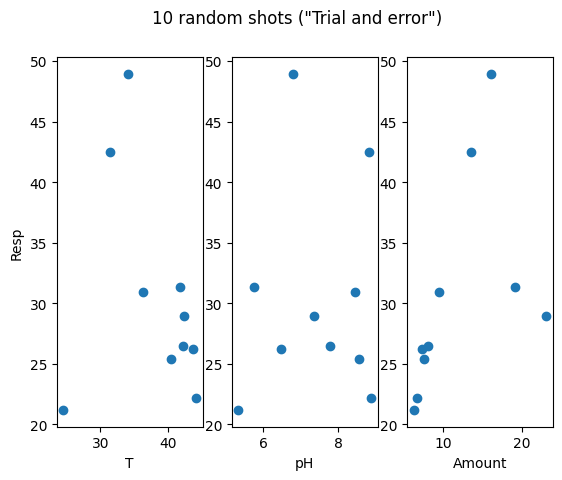

In [197]:
fig, axs = plt.subplots(1,3)
fig.suptitle('10 random shots ("Trial and error")')
axs[0].scatter(X[:][0], Response)
axs[1].scatter(X[:][1], Response)
axs[2].scatter(X[:][2], Response)

axs[0].set_xlabel('T')
axs[1].set_xlabel('pH')
axs[2].set_xlabel('Amount')
axs[0].set_ylabel('Resp')

fig.subplots_adjust(hspace=0.5)

# Simplex optimization
It is time to see how a stepwise optimization can be performed in a more systematic way. The simplex method means a strategy for navigating through the variable space, heading for an optimum. In the three-dimensional space a simplex has corners or vertices V1 through V4 (one more than the
number of experimental variables) and the response is obtained for all these experimental conditions.

The simplex optimization strategy is to move the simplex by replacing the worst point (with respect to the optimization goal) by reflecting it through the mean value of the others. Then sort the vertices with
respect to the responses, so that V1 is the best and V4 is the worst point. Calculate a new point, V5 according to:
$$
\begin{equation}
V5 = (V1+V2+V3)/3 - ( V4 – (V1+V2+V3)/3 ) = 2*(V1+V2+V3)/3 - V4
\end{equation}
$$

Obtain the response for **V5** and replace **V4** with **V5**, so that **V4** now stands for the new vertex with the new response value. The simplex should now have moved towards the optimum (although maybe not
the straight way...) and the procedure is repeated. The iteration involves the following steps:

1. Sort the simplex points (**V1** through **V4**) according to the responses and calculate **V5**
2. Perform the experiment according to **V5**
3. Replace the worst point (V4) with the new point (**V5**)

Let see how we can do this in python...

In [257]:
XT=[20.0, 23.0, 21.5]
XpH=[5.0, 5.0, 5.4]
XA=[15.0, 15.0, 15.0]


add the 4th point

In [258]:
XT.append(21.5)
XpH.append(5.1)
XA.append(16.6)

X=[XT, XpH, XA]

In [259]:
X

[[20.0, 23.0, 21.5, 21.5], [5.0, 5.0, 5.4, 5.1], [15.0, 15.0, 15.0, 16.6]]

Perform Experiment

In [260]:
Response=[]
for i in range(len(X[0][:])):
  Xexp=[X[0][i], X[1][i],X[2][i]]
  Resp=experiment(Xexp)
  Response.append(Resp)

Resp=pd.DataFrame({'T':X[0][:],'pH':X[1][:], 'Amount':X[2][:],'Response':Response})
Resp

,T,pH,Amount,Response
0,20.0,5.0,15.0,21.620180
1,23.0,5.0,15.0,22.815192
2,21.5,5.4,15.0,23.709285
3,21.5,5.1,16.6,22.696401


<Axes: >

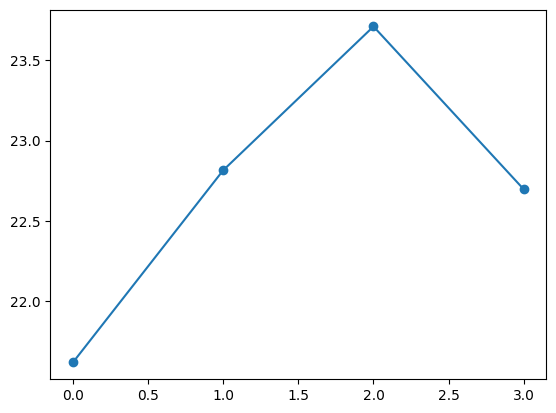

In [261]:
Resp['Response'].plot(marker='o')

Sort the data

In [262]:
Resp['Response'].sort_values(ascending=False)

,Response
2,23.709285
1,22.815192
3,22.696401
0,21.620180


Compute next point (**V5**)

In [263]:
V1 = np.array([Resp['T'].iloc[2], Resp['pH'].iloc[2], Resp['Amount'].iloc[2]])
V2 = np.array([Resp['T'].iloc[1], Resp['pH'].iloc[1], Resp['Amount'].iloc[1]])
V3 = np.array([Resp['T'].iloc[3], Resp['pH'].iloc[3], Resp['Amount'].iloc[3]])
V4 = np.array([Resp['T'].iloc[0], Resp['pH'].iloc[0], Resp['Amount'].iloc[0]])

V5 = 2*(V1 + V2 + V3)/3-V4

V5

array([24.        ,  5.33333333, 16.06666667])

In [264]:
newresp

25.175766780741156

In [265]:

Xexp=[V5[0], V5[1],V5[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.0,5.000000,15.000000,21.620180
1,23.0,5.000000,15.000000,22.815192
2,21.5,5.400000,15.000000,23.709285
3,21.5,5.100000,16.600000,22.696401
4,24.0,5.333333,16.066667,25.061096


<Axes: >

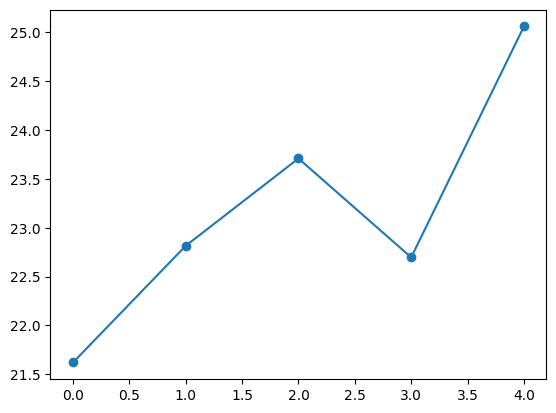

In [267]:
Resp['Response'].plot(marker='o')

In [268]:
Resp['Response'].sort_values(ascending=False)

,Response
4,25.061096
2,23.709285
1,22.815192
3,22.696401
0,21.620180


In [269]:
V1 = np.array([Resp['T'].iloc[4], Resp['pH'].iloc[4], Resp['Amount'].iloc[4]])
V2 = np.array([Resp['T'].iloc[2], Resp['pH'].iloc[2], Resp['Amount'].iloc[2]])
V3 = np.array([Resp['T'].iloc[1], Resp['pH'].iloc[1], Resp['Amount'].iloc[1]])
V4 = np.array([Resp['T'].iloc[3], Resp['pH'].iloc[3], Resp['Amount'].iloc[3]])

V5 = 2*(V1 + V2 + V3)/3-V4

V5

array([24.16666667,  5.38888889, 14.11111111])

In [270]:
Xexp=[V5[0], V5[1],V5[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.620180
1,23.000000,5.000000,15.000000,22.815192
2,21.500000,5.400000,15.000000,23.709285
3,21.500000,5.100000,16.600000,22.696401
4,24.000000,5.333333,16.066667,25.061096
5,24.166667,5.388889,14.111111,24.786295


<Axes: >

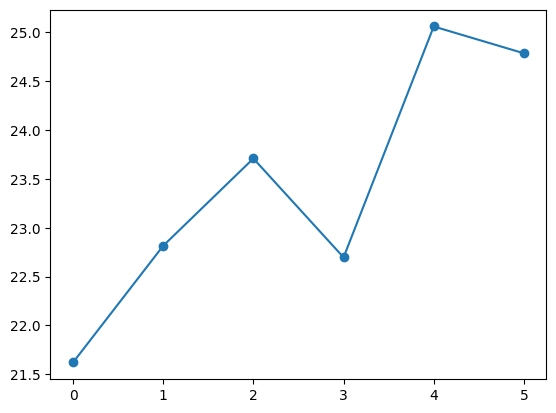

In [271]:
Resp['Response'].plot(marker='o')

In [272]:
Resp['Response'].sort_values(ascending=False)

,Response
4,25.061096
5,24.786295
2,23.709285
1,22.815192
3,22.696401
0,21.620180


In [273]:
V1 = np.array([Resp['T'].iloc[4], Resp['pH'].iloc[4], Resp['Amount'].iloc[4]])
V2 = np.array([Resp['T'].iloc[5], Resp['pH'].iloc[5], Resp['Amount'].iloc[5]])
V3 = np.array([Resp['T'].iloc[2], Resp['pH'].iloc[2], Resp['Amount'].iloc[2]])
V4 = np.array([Resp['T'].iloc[1], Resp['pH'].iloc[1], Resp['Amount'].iloc[1]])

V5 = 2*(V1 + V2 + V3)/3-V4

V5

array([23.44444444,  5.74814815, 15.11851852])

In [274]:
Xexp=[V5[0], V5[1],V5[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.620180
1,23.000000,5.000000,15.000000,22.815192
2,21.500000,5.400000,15.000000,23.709285
3,21.500000,5.100000,16.600000,22.696401
4,24.000000,5.333333,16.066667,25.061096
5,24.166667,5.388889,14.111111,24.786295
6,23.444444,5.748148,15.118519,26.904464


<Axes: >

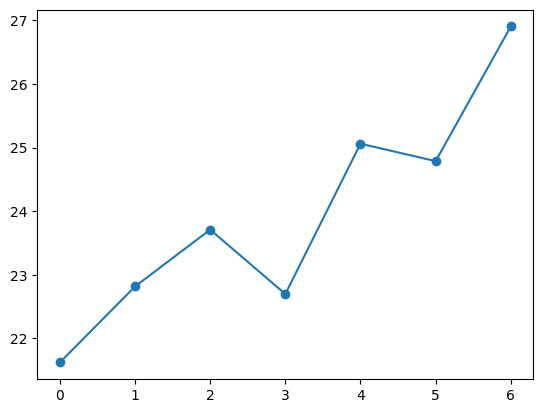

In [275]:
Resp['Response'].plot(marker='o')

In [276]:
Resp['Response'].sort_values(ascending=False)

,Response
6,26.904464
4,25.061096
5,24.786295
2,23.709285
1,22.815192
3,22.696401
0,21.620180


In [278]:
Resp['Response'].sort_values(ascending=False).index[0:4]

Index([6, 4, 5, 2], dtype='int64')

In [283]:
order=[Resp['Response'].sort_values(ascending=False).index[0:4]]
V1 = np.array([Resp['T'].iloc[order[0][0]], Resp['pH'].iloc[order[0][0]], Resp['Amount'].iloc[order[0][0]]])
V2 = np.array([Resp['T'].iloc[order[0][1]], Resp['pH'].iloc[order[0][1]], Resp['Amount'].iloc[order[0][1]]])
V3 = np.array([Resp['T'].iloc[order[0][2]], Resp['pH'].iloc[order[0][2]], Resp['Amount'].iloc[order[0][2]]])
V4 = np.array([Resp['T'].iloc[order[0][3]], Resp['pH'].iloc[order[0][3]], Resp['Amount'].iloc[order[0][3]]])

V5 = 2*(V1 + V2 + V3)/3-V4

V5

array([26.24074074,  5.58024691, 15.19753086])

In [284]:
Xexp=[V5[0], V5[1],V5[2]]
newexp=experiment(Xexp)
newresp=(newexp)
newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
Resp = Resp._append(newresponse, ignore_index=True)

Resp

,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.620180
1,23.000000,5.000000,15.000000,22.815192
2,21.500000,5.400000,15.000000,23.709285
3,21.500000,5.100000,16.600000,22.696401
4,24.000000,5.333333,16.066667,25.061096
5,24.166667,5.388889,14.111111,24.786295
6,23.444444,5.748148,15.118519,26.904464
7,26.240741,5.580247,15.197531,27.909536


<Axes: >

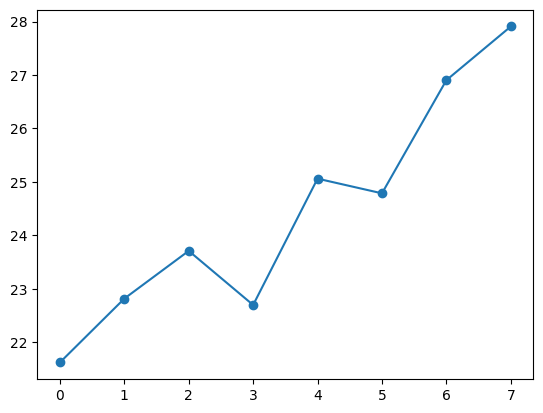

In [285]:
Resp['Response'].plot(marker='o')

Let us automatize it further

In [289]:
for i in range(0,10):

   order=[Resp['Response'].sort_values(ascending=False).index[0:4]]
   V1 = np.array([Resp['T'].iloc[order[0][0]], Resp['pH'].iloc[order[0][0]], Resp['Amount'].iloc[order[0][0]]])
   V2 = np.array([Resp['T'].iloc[order[0][1]], Resp['pH'].iloc[order[0][1]], Resp['Amount'].iloc[order[0][1]]])
   V3 = np.array([Resp['T'].iloc[order[0][2]], Resp['pH'].iloc[order[0][2]], Resp['Amount'].iloc[order[0][2]]])
   V4 = np.array([Resp['T'].iloc[order[0][3]], Resp['pH'].iloc[order[0][3]], Resp['Amount'].iloc[order[0][3]]])

   V5 = 2*(V1 + V2 + V3)/3-V4
   Xexp=[V5[0], V5[1],V5[2]]
   newexp=experiment(Xexp)
   newresp=(newexp)
   newresponse={'T':V5[0],'pH':V5[1], 'Amount':V5[2],'Response':newresp}
   Resp = Resp._append(newresponse, ignore_index=True)


Resp


,T,pH,Amount,Response
0,20.000000,5.000000,15.000000,21.620180
1,23.000000,5.000000,15.000000,22.815192
2,21.500000,5.400000,15.000000,23.709285
3,21.500000,5.100000,16.600000,22.696401
4,24.000000,5.333333,16.066667,25.061096
5,24.166667,5.388889,14.111111,24.786295
6,23.444444,5.748148,15.118519,26.904464
7,26.240741,5.580247,15.197531,27.909536
8,24.956790,5.718930,16.810700,28.969009
9,25.761317,6.031550,15.351166,31.871534
